In [ ]:
import random, re, json, pathlib, logging, time, argparse, pprint 
import pandas as pd
import numpy as np
import circlify as crcf
import matplotlib.pyplot as plt
import importlib.resources as rsrc

import postprocess.postprocess as pspr


In [ ]:
sdg_names = [f'SDG {count}' for count in range(1,18,1)]
sdg_color_ls = ['#e5243b','#dda63a','#4c9f38',
'#c5192d','#ff3a21','#26bde2',
'#fcc30b','#a21942','#fd6925',
'#dd1367','#fd9d24','#bf8b2e',
'#3F7E44','#0a97d9','#56c02b',
'#00689d','#19486a']
sdg_colors = {label : color for label, color in zip(sdg_names,sdg_color_ls)}

In [ ]:
data = [
        {'id': 'Green Deal', 'datum': 6964195249, 'children' : [
              {'id' : "SDG 1", 'datum': 450448697,
                   'children' : [
                     {'id' : "Target 1.1", 'datum' : 308865000},
                     {'id' : "Target 1.2", 'datum' : 107550697},
                     {'id' : "Target 1.3", 'datum' : 34033000} 
                   ]},
              {'id' : "SDG 2", 'datum' : 278095425, 
                   'children' : [
                     {'id' : "Target 2.1", 'datum' : 192612000},
                     {'id' : "Target 2.2", 'datum' : 45349000},
                     {'id' : "Target 2.3", 'datum' : 40134425}
                   ]}],
        },
        {'id': 'Digital age', 'datum': 3564195249, 'children' : [
              {'id' : "SDG 3", 'datum' : 209246682,  
                   'children' : [
                     {'id' : "Target 3.1", 'datum' : 81757600},
                     {'id' : "Target 3.2", 'datum' : 65447374},
                     {'id' : "Target 3.3", 'datum' : 62041708}
                   ]},
              {'id' : "SDG 4", 'datum' : 311929000,  
                   'children' : [
                     {'id' : "Target 4.1", 'datum' : 154729000},
                     {'id' : "Target 4.2", 'datum' : 79221000},
                     {'id' : "Target 4.3", 'datum' : 77979000}
                   ]}],
        },
        {'id': 'Economy4People', 'datum': 4564195249, 'children' : [
              {'id' : "SDG 5", 'datum' : 2745929500,  
                   'children' : [
                     {'id' : "Target 5.1", 'datum' : 1336335000},
                     {'id' : "Target 5.2", 'datum' : 1178225000},
                     {'id' : "Target 5.3", 'datum' : 231369500}
                   ]},
              {'id' : "SDG 6", 'datum' : 3545929500,  
                   'children' : [
                     {'id' : "Target 6.1", 'datum' : 936335000},
                     {'id' : "Target 6.2", 'datum' : 1878225000},
                     {'id' : "Target 6.3", 'datum' : 271369500}
                   ]}]
        }
       ]

In [ ]:
# Compute circle positions thanks to the circlify() function
circles = crcf.circlify(
    data, 
    show_enclosure=False, 
    target_enclosure=crcf.Circle(x=0, y=0, r=1)
)

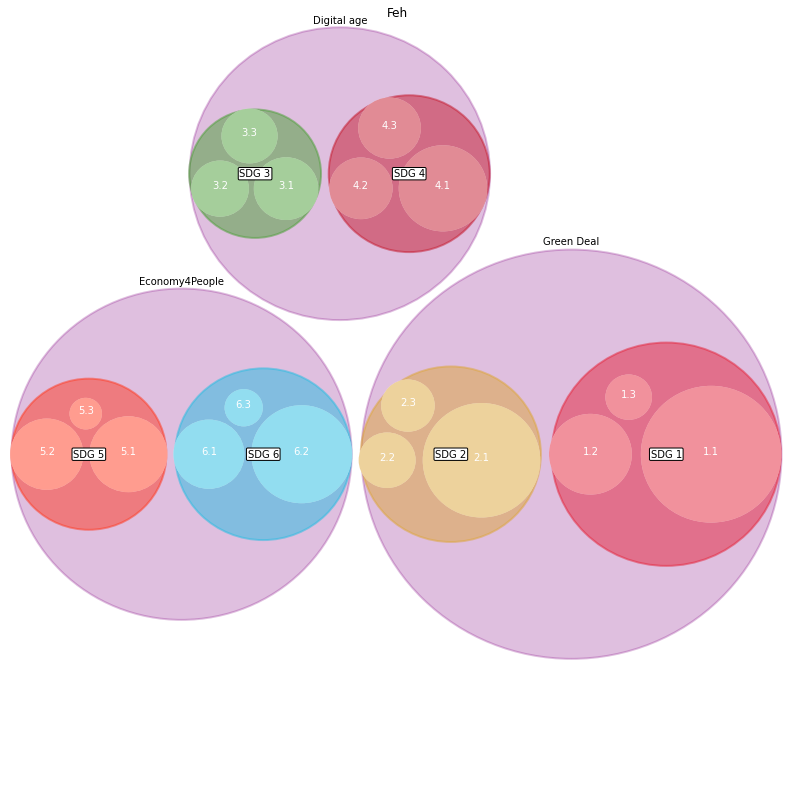

In [29]:
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(14,14))

# Title
ax.set_title('Feh')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

rf={1:0.975, 2:0.95, 3:0.925} #reduction factor

# Print circles at pp level:
for circle in circles:
    if circle.level != 1:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r*rf[circle.level], alpha=0.25, linewidth=2, color='purple'))

# Print circles at goal level:
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r*rf[circle.level], alpha=0.5, linewidth=2, color=sdg_colors[label]))

# Print circle at target level:
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    color = re.sub(r'Target (\d{,2}).[a-z0-9]', r'SDG \1', label)
    label = label.replace('Target ','')
    ax.add_patch( plt.Circle((x, y), r*rf[circle.level], linewidth=0, color="white"))
    ax.add_patch( plt.Circle((x, y), r*rf[circle.level], alpha=0.5, linewidth=0, color=sdg_colors[color]))
    plt.annotate(label, (x,y ), ha='center', color="white")

# Print labels for the continents
for circle in circles:
    if circle.level not in (1,2):
      continue
    x, y, r = circle
    label = circle.ex["id"]
    if circle.level == 2:
        plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.125))
    elif circle.level == 1:
        plt.annotate(label, (x,y+r), ha='center', color="black")



In [ ]:
target_df = pd.read_pickle("rrp_target_df.pkl")

goal_df = pd.read_pickle("rrp_goal_df.pkl")

In [ ]:
goal_df.head()

In [ ]:

target_df['Target'] = pspr.stringify_id(target_df['Target'])

results_dict = {}

with rsrc.path("postprocess", "goal_target_list.xlsx") as res_path:
    sdg_df = pd.read_excel(res_path)

results_dict['target_dat'] = pspr.aggregate_to_targets(target_df, sdg_df)

results_dict['goal_dat'] = pspr.aggregate_to_goals(goal_df, sdg_df)

results_dict['goals_grouped_by_document'] = pspr.group_byNAme_and_get_goaloverview(results_dict['target_dat'], results_dict['goal_dat'], sdg_df)

In [ ]:
jrc = pd.read_excel('output/JRC_/output/6-results/results_.xlsx', sheet_name='goals_grouped_by_documents')
D_units = pd.read_excel('output/JRC_/output/6-results/Projects overview_DirD.xlsx',usecols=['PP','PRJ','Unit'])
jrc.head()
#jrc.drop(columns='Policy', inplace=True)
jrc_folder = jrc['Policy'].str.split('/',expand=True)
jrc_folder['Policy'] = jrc_folder[[0,1]].agg(lambda x: f'{x[0]}/{x[1]}', axis=1)
jrc_folder['PP']=jrc_folder[1].apply(lambda doc: int(re.search(r'(?<=PP_)\d{5}(?<!_)',doc).group(0)))
jrc_folder['PRJ']=jrc_folder[1].apply(lambda doc: int(re.search(r'(?<=_PRJ_)\d{5}(?<!_\d{6}.docx)',doc).group(0)))
jrc_folder = jrc_folder.join(D_units.set_index('PRJ'), on='PRJ', how='inner',lsuffix='_re', rsuffix='_jpb')
jrc_folder = jrc_folder.drop_duplicates().reset_index()
jrc = jrc.merge(jrc_folder, on='Policy', how='right')
jrc = jrc.groupby([0,'Unit','goal_id'])
DirD = jrc['Count'].sum().loc['DirD']
#DirD.head(50)
dird_dict=DirD.to_dict()
DirD.to_excel('DirD_gl.xlsx')
#print(DirD.to_list())#.pivot('Subject_id', 'Subject', 'Score').to_dict('index')
# print(jrc.columns.values.tolist())
# jrc=jrc.drop(columns=['Unnamed: 1', 'index_x', 'index_y','PP_re'])
#jrc.pivot([0,'Unit','PRJ'], 'goal_id', 'Count').to_dict('index')

# jrc_bubblechart={'name': 'sdgs', 'children':[]}

# units = list(set([unit for unit, id in dird_dict.keys()]))

# print(units)

# #{'name': 'sdgs'}
# total_value = 0
# unit=0
# for key, value in dird_dict.items():
#     temp_dict={'name': f'SDG {key[1]}', 'size':value}
#     #total_value+=value
#     jrc_bubblechart['children'].append({'name':key[0],'size':total_value,'children':[temp_dict]})
#     # jrc_bubblechart['name']=key[0]
#     # jrc_bubblechart['children'

# print(jrc_bubblechart)

In [ ]:
jrc.head()

In [ ]:
#create grouping variable by path
folders=results_dict['goals_grouped_by_document']['Policy'].str.split('/',expand=True)
folders=folders.join(results_dict['goals_grouped_by_document'])
#folders.head()
folders=folders.groupby([0, 'Goal'])

In [ ]:
#folders.head()
folders.get_group('RRP_IT')

In [ ]:
#create series by group
EUSem=folders['Count'].sum().loc['EU_Semester'].to_list()
Rrp=folders['Count'].sum().loc['RRP_IT'].to_list()
print(len(EUSem),len(Rrp))


In [ ]:
df = pd.DataFrame({
    'Name': [f'SDG {count}' for count in range(1,18,1)],
    'Value': [random.randint(1, 400) for i in range(1,18,1)]
})

color_ls = ['#e5243b','#dda63a','#4c9f38',
'#c5192d','#ff3a21','#26bde2',
'#fcc30b','#a21942','#fd6925',
'#dd1367','#fd9d24','#bf8b2e',
'#37e440','#0a97d9','#56c02b',
'#00689d','#19486a']
sdg_color = {label : color for label, color in zip(df['Name'].tolist(),color_ls)}

In [ ]:
plt.figure(figsize=[15, 10])
# Data to be plotted
#Rrp = [random.randint(1, 400) for i in range(1,18,1)]
RecPlan = [random.randint(1, 400) for i in range(1,18,1)]
#EUSem = [random.randint(1, 400) for i in range(1,18,1)]
# # Using numpy to group 3 different data with bars
X = np.arange(len(Rrp))
# # Passing the parameters to the bar function, this is the main function which creates the bar plot
# # Using X now to align the bars side by side
plt.bar(X, Rrp, color = sdg_color.values(), alpha = 1, width = 0.25)    
plt.bar(X + 0.25, EUSem, color = sdg_color.values(), alpha = 0.75, width = 0.25)
plt.bar(X + 0.5, RecPlan, color = sdg_color.values(), alpha = 0.5, width = 0.25)
# Creating the legend of the bars in the plot
plt.legend(['Rrp', 'RecPlan', 'EuSem'])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,18,1)], df['Name'].tolist())
# Giving the tilte for the plot
plt.title("Count of references within the documents") #within {path.name}
# Namimg the x and y axis
#plt.xlabel('Countries')
plt.ylabel('Counts')
# Saving the plot as a 'png'
# if save_plot=True:
#     plt.savefig(svg_filepath_variable)
# Displaying the bar plot
plt.show()

In [ ]:
# results_dict['goals_grouped_by_document']=results_dict['goals_grouped_by_document'].drop(columns = results_dict['goals_grouped_by_document'].columns[[0]], inplace=True)

In [ ]:
results_dict['goals_grouped_by_document']=results_dict['goals_grouped_by_document'].rename_axis(['names',0])

In [ ]:
results_dict['goals_grouped_by_document'].groupby("names").groups
#results_dict['goals_grouped_by_document'].groups 

In [ ]:
feh = results_dict['goals_grouped_by_document'][['Goal','Count']].to_dict('index')
print(feh)

In [ ]:
for name in results_dict['goals_grouped_by_document']:
    print(name)


In [ ]:
circles = crcf.circlify(
    results_dict['goals_grouped_by_document'][['Goal','Count']].to_dict('index'), 
    show_enclosure=False, 
    target_enclosure=crcf.Circle(x=0, y=0, r=1)
)